# sam和hawp

In [1]:
import numpy as np
import random 
import torch
import matplotlib.pyplot as plt
import cv2
import os
# COCO dependencies
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from matplotlib.image import imread
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# sam相关
from segment_anything import sam_model_registry, SamPredictor
sam_checkpoint = "/Users/jhyang/Desktop/cv-graduate/segment-anything-edge-detection-main/working/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
# hawp相关
from hawp.base import to_device, setup_logger, MetricLogger, save_config
from hawp.base import show
from hawp.fsl.solver import make_lr_scheduler, make_optimizer
from hawp.fsl.config import cfg as model_config
from hawp.ssl.config import Config, load_config
from hawp.ssl.datasets import dataset_util
from hawp.ssl.models import MODELS
from pathlib import Path
import argparse
import cv2
import copy
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from urllib.parse import urlparse
metarch = 'HAWP'
cfg = '/Users/jhyang/Desktop/cv-graduate/hawp/hawp/ssl/config/hawpv3.yaml'
ckpt = '/Users/jhyang/Desktop/cv-graduate/hawp/checkpoints/hawpv3-imagenet-03a84.pth'
threshold = 0.5
#img = '/Users/jhyang/Desktop/cv-graduate/segment-anything/data/tmp/tmp_data/14085.jpg'
width = 512
height = 512
whitebg = 0.0
saveto = None
ext = 'png'
model_config.merge_from_file(cfg)
model = MODELS[metarch](model_config, gray_scale=True)
model = model.eval().to(device)
state_dict = torch.load(ckpt, map_location='cpu')
model.load_state_dict(state_dict)
show.Canvas.show = True
painter = show.painters.HAWPainter()

__init__


In [3]:
#可视化功能函数
#点可视化
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    #print(pos_points)
    neg_points = coords[labels==0]
    #print(neg_points)
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
#分割结果mask可视化
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)   

In [4]:
#coco数据集加载函数，调用需要联网+梯子+上传annFile
annFile='instances_val2017.json'
# initialize COCO api for instance annotations
cocoGt=COCO(annFile)
def load_1_COCO_image():
    # randomly sample an image from COCO Val split 2017
    imgIds = sorted(cocoGt.getImgIds())
    imgIds = imgIds[0:3] # get first 3 images
    image_id = imgIds[np.random.randint(3)] # get a random image id
    img = cocoGt.loadImgs(image_id)[0]#加载image_id对应的图片信息

    # load and display image
    image = io.imread(img['coco_url']) 

    # tempImg to be cropped for some functions
    tempImg = Image.fromarray(image) 
    tempImg.save('coco100_images/{0}.jpg'.format(image_id))
    # 要看tempImg就取消注释
    # plt.imshow(tempImg)
    # plt.axis('off')
    # plt.show()
    return imgIds, image, image_id, tempImg
# imgIds：一个包含COCO数据集中前100张图像的ID的列表。 list 100
# image：一个NumPy队列，表示来自COCO数据集中加载的一张图像。 ndarray
# image_id：一个整数，表示从COCO数据集中加载的一张图像的ID。 int
# tempImg：一个PIL图像对象，表示从COCO数据集中加载的一张图像。 Image 可以直接plt.imshow
def load_COCO_images(num):
    # randomly sample an image from COCO Val split 2017
    imgIds = sorted(cocoGt.getImgIds())
    imgIds = imgIds[0:num] # get first 3 images
    return imgIds
# imgIds：一个包含COCO数据集中前100张图像的ID的列表。 list 100
# image：一个NumPy队列，表示来自COCO数据集中加载的一张图像。 ndarray
# image_id：一个整数，表示从COCO数据集中加载的一张图像的ID。 int
# tempImg：一个PIL图像对象，表示从COCO数据集中加载的一张图像。 Image 可以直接plt.imshow


loading annotations into memory...
Done (t=1.09s)
creating index...
index created!


In [ ]:
#好像也可以交给cuda 后面再想想
def move_towards_line(point, line, img):
    cv2.imwrite('ori.png', ori_img)
    x0, y0 = point
    x1, y1, x2, y2 = line
    cv2.circle(img, (x0, y0), 1, (255, 0, 0), -1)
    cv2.line(img, (x1,y1), (x2,y2), (0, 255, 0), 1)
    if x1==x2:
        intersection=(x1,y0)
    elif y1==y2:
        intersection=(x0,y1)
    else:
        k = (y2 - y1) / (x2 - x1)
        k_vertical = -1 / k
        b = y1 - k * x1
        b_vertical=y0-k_vertical*x0
        x = (b_vertical - b) / (k-k_vertical)
        y = k_vertical * x +  b_vertical
        intersection = (int(abs(x)), int(abs(y)))
    print(intersection)
    cv2.circle(img, intersection, 1, (0, 0, 255), -1)
    cv2.imwrite('test.png', img)
    return img

In [ ]:
#投影函数
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
#point line 一一对应，投影点保存在
def project_to_line(points, lines):
    # 创建LineString对象和Point对象
    ls_list = [LineString(line) for line in lines]
    pt_list = [Point(point) for point in points]
    # 计算每个点到对应的线段的投影点坐标
    projection_list = []
    projection_plist = []
    for i, pt in enumerate(pt_list):
        ls = ls_list[i]
        projection = ls.interpolate(ls.project(pt))
        projection_plist.append(projection)
        projection_list.append((projection.x,projection.y))
    ### 可视化 
    # # 将线段和点绘制到图像上
    # fig, ax = plt.subplots()
    # for ls in ls_list:
    #     ax.plot(*ls.xy)
    # for pt in pt_list:
    #     ax.plot(*pt.xy, 'o')
    # # 将投影点绘制到图像上
    # for projection in projection_plist:
    #     ax.plot(*projection.xy, 'o')
    # # 将线段和投影点之间的连线绘制到图像上
    # for pt, projection in zip(pt_list, projection_plist):
    #     ax.plot([pt.x, projection.x], [pt.y, projection.y], '--')
    # # 显示图像
    # plt.show()
    ###
    return projection_list

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


lines_pred tensor([[5.2238e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.7075e-01, 1.3690e-01, 8.9862e-01, 3.0433e-01],
        [8.4045e-01, 2.1646e-01, 9.7760e-01, 8.2679e-01],
        ...,
        [1.2700e+02, 1.2700e+02, 1.2318e+02, 1.2291e+02],
        [1.2700e+02, 1.2700e+02, 1.2552e+02, 1.2416e+02],
        [1.2700e+02, 1.2624e+02, 1.2587e+02, 1.2534e+02]])
hafm_decoding


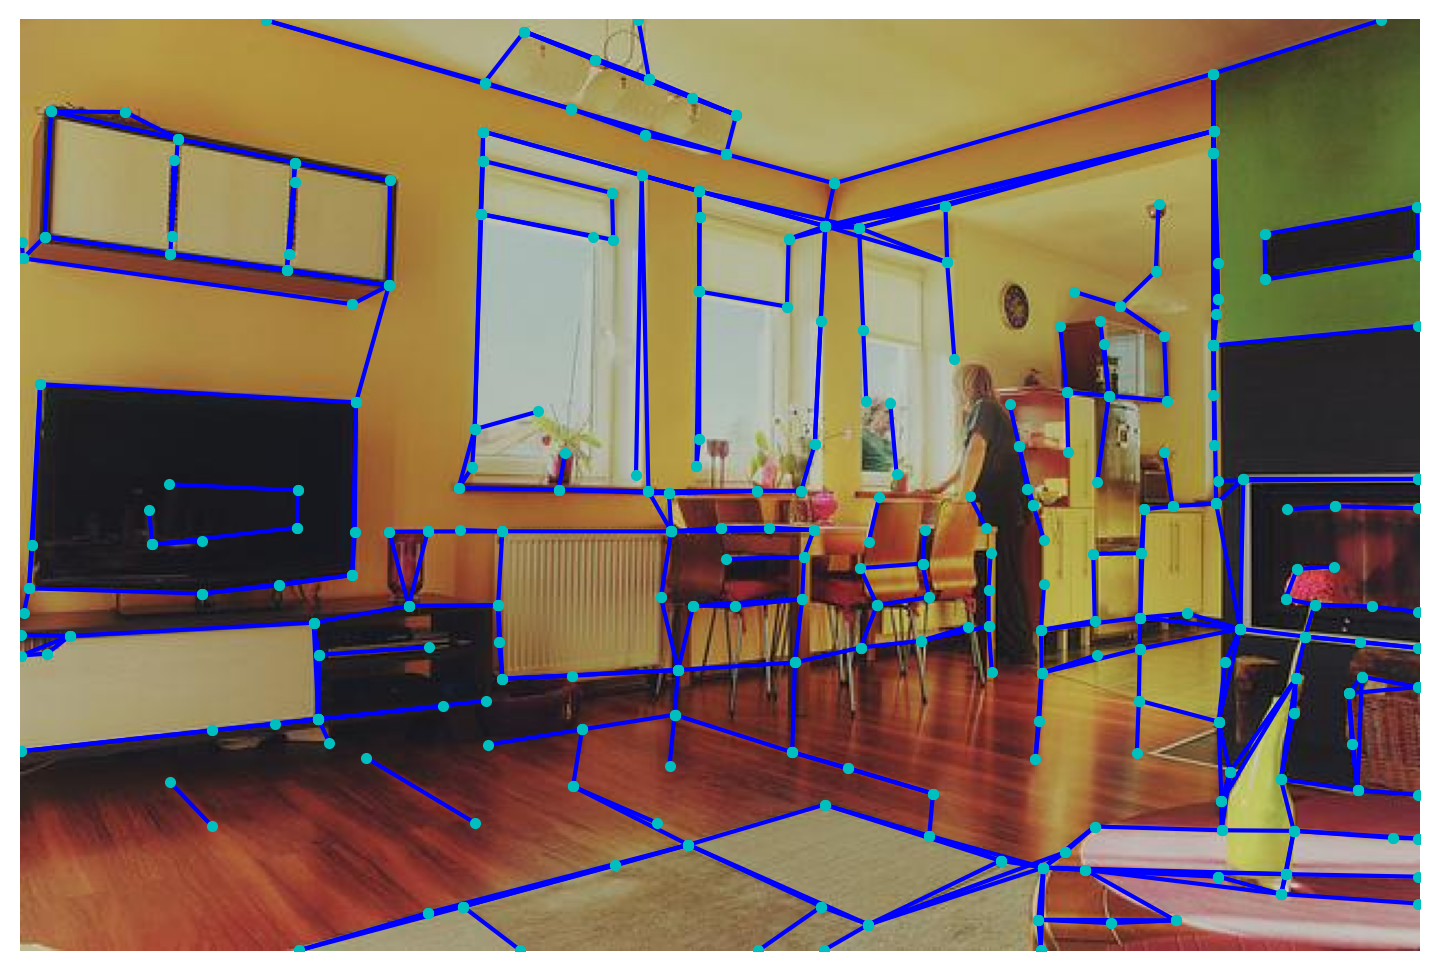

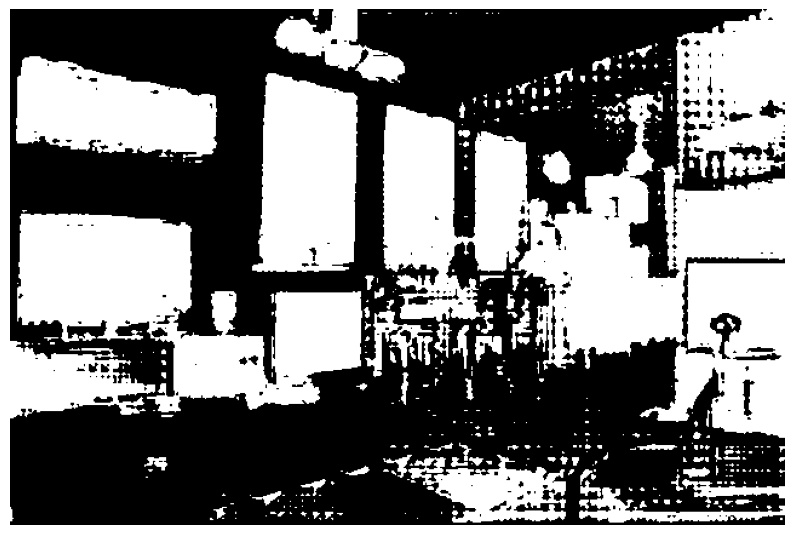

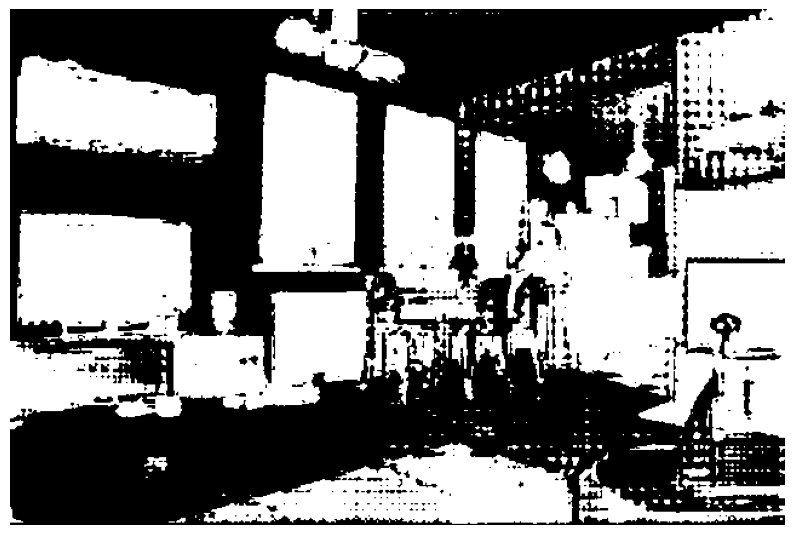

In [6]:
#sam+hawp
from skimage import io, img_as_ubyte
from csrc import _C
imgIds = load_COCO_images(3)
for i,imgId in enumerate(imgIds):
    img = cocoGt.loadImgs(imgId)[0]
    I = io.imread(img['coco_url'])
    # 将图像保存为JPEG文件，给hawp画图
    io.imsave('image.jpg', img_as_ubyte(I))
    ##hawp分割线
    image = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
    ori_shape = image.shape[:2]
    image_cp = copy.deepcopy(image)
    image_ = cv2.resize(image_cp, (width, height))
    image_ = torch.from_numpy(image_).float() / 255.0
    image_ = image_[None, None].to(device)
    meta = {
        'width': ori_shape[1],
        'height': ori_shape[0],
        'filename': ''
    }
    with torch.no_grad():
        outputs, _ = model(image_, [meta])
        input_point=outputs.juncs_pred.numpy()
        lines=outputs.lines_pred.numpy()
        input_label_r=np.array([1] *len(input_point))
    with show.image_canvas('image.jpg') as ax:
        painter.draw_wireframe(ax, outputs)
    ##sam分割线
    predictor.set_image(I)
    masks, scores, logits = predictor.predict(
point_coords=input_point,
point_labels=input_label_r,
multimask_output=True,
)  
    #置信度最高的mask
    mask = masks[scores.argmax()]
    mask_img = np.uint8(mask * 255)
    cv2.imwrite('best_mask.png',mask_img)
    plt.imshow(mask_img,cmap='gray')
    plt.axis('off')
    plt.show()
    #三张mask合并的mask
    merged_mask = np.logical_or(np.logical_or(masks[0], masks[1]), masks[2])
    merged_mask = np.uint8(merged_mask * 255)
    cv2.imwrite('merged_mask.png', merged_mask.astype(np.uint8) * 255)
    plt.imshow(merged_mask,cmap='gray')
    plt.axis('off')
    plt.show()
    #afm 先用merged_mask试试
    lines_tensor=outputs.lines_pred.cuda()
    lmap, labels, tmap = _C.encodels(lines_tensor,height,width,height,width,lines_tensor.size(0))  
    dismap = torch.sqrt(lmap[0]**2+lmap[1]**2)[None]
    # for 遍历图像像素点： #这一步其实可以交给cuda来做 先用python试试看多久
    # if 像素点 is mask and 像素点 tmap ！= -1（说明有分配）
    #     move_towards_line(point, line, img)#函数逻辑 交点变成mask 原像素点变黑 其实只用求出交点坐标在图像中变一下即可
    # move_towards_line(point, line, img)
    # 遍历二维数组的每个元素
    #!! 可以不用遍历 
    # 1.筛距离：选出dismap中距离<指定像素点 的索引
    dismap_indices=torch.nonzero(dismap < 4.0) #(limited_pixel_num,2)
    # 2.筛分配线段
    #用dismap_indices中的值作为索引，访问tmap的值并保留值不为-1的索引值和元素值
    tmap_indices = torch.nonzero(tmap != -1)
    # 3.筛mask像素点
    mask_img_indices = torch.nonzero(merged_mask != 0)
    #三个索引序列求交集
    # 将张量看作是集合
    set_dis = set(map(tuple, dismap_indices.tolist()))
    set_tmap = set(map(tuple, tmap_indices.tolist()))
    set_mask = set(map(tuple, mask_img_indices.tolist()))
    #4.求交集，交集为需要投影到线段上的像素点坐标
    pixels_project = list(map(list, set_dis & set_tmap & set_mask))
    #[(1, 2), (5, 6)]
    #5.取出投影点对应的直线坐标
    #通过访问tmap找到pixel对应的线段标号，根据线段标号从ndarray中取出线段坐标，并保存在list中
    lines_list=[]
    for i,j in pixels_project:
        line_index=tmap[i][j]
        x1,y1,x2,y2=lines[line_index]
        lines_list.append([(x1, y1),(x2,y2)])
    #6.将mask像素点投影到线段上
    #6.1 求出所有线段投影点（可以考虑使用cuda，放到afm里面算）
    projection_list=project_to_line(pixels_project,lines_list)
    #6.2 批量改变像素值 所有线段投影点变为mask 原mask像素点变0
    result_merged_mask=merged_mask
    for x, y in projection_list:
        result_merged_mask[int(round(y)), int(round(x))] = 255
    for x, y in pixels_project:
        result_merged_mask[y, x] = 0
    # visualize the image using Matplotlib
    plt.imshow(result_merged_mask)
    plt.show()
    plt.imshow(merged_mask)
    plt.show()
    break#测试一张图